In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [441]:
q="TGGAAAG"
t="TCTAGCG"

In [478]:
x = 4
o = 6
e = 2

In [219]:
def visualize_matrices(q,t,M,I,D):
    # visualize matrices using seaborn heatmap and putting the strings as labels
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    for i, matrix in enumerate([M,I,D]):
        sns.heatmap(matrix,annot=True,fmt=".0f",ax=ax[i],cbar=False, vmin=0, vmax=20)
        ax[i].set_xlabel("t")
        ax[i].set_ylabel("q")
        ax[i].set_xticklabels([""]+list(t))
        ax[i].set_yticklabels([""]+list(q), rotation=0)
        

    ax[0].set_title("M")
    ax[1].set_title("I")
    ax[2].set_title("D")
    plt.show()

In [220]:
def swg(q,t):
    # initialization
    M = np.zeros((len(q)+1,len(t)+1),dtype=float)
    I = np.zeros((len(q)+1,len(t)+1),dtype=float)
    D = np.zeros((len(q)+1,len(t)+1),dtype=float)
    # set all matrices to None
    M[:,:] = I[:,:] = D[:,:] = None
    M[0,0] = I[0,0] = D[0,0] = 0
    for v in range(1,len(q)+1):
        M[v,0] = M[0,v] = np.inf
        # set the first column of I to inf
        I[v,0] = np.inf
        I[0,v] = o + (v-1)*e
        
        D[0,v] = np.inf
        D[v,0] = o + (v-1)*e

    visualize_matrices(q,t,M,I,D)

    for v in range(1,len(q)+1):
        for h in range(1,len(t)+1):
            if v==1 and h==1:
                print(v, h-1, M[v, h-1]+o+e, I[v,h-1]+e)
            I[v,h] = min(M[v-1, h]+o+e, I[v-1,h]+e)
            D[v,h] = min(M[v, h-1]+o+e, D[v,h-1]+e)
            if q[v-1] != t[h-1]:
                M[v,h] = min(M[v-1,h-1]+x,I[v,h],D[v,h])
            else:
                M[v,h] = min(M[v-1,h-1],I[v,h],D[v,h])
        visualize_matrices(q,t,M,I,D)

In [443]:
q = "GAGATA"
t = "GATACA"

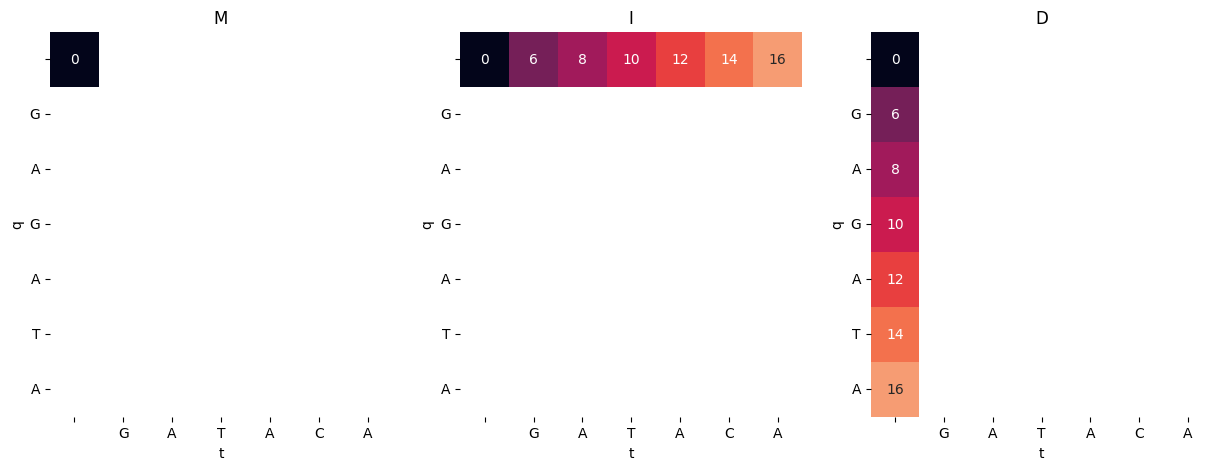

1 0 inf inf


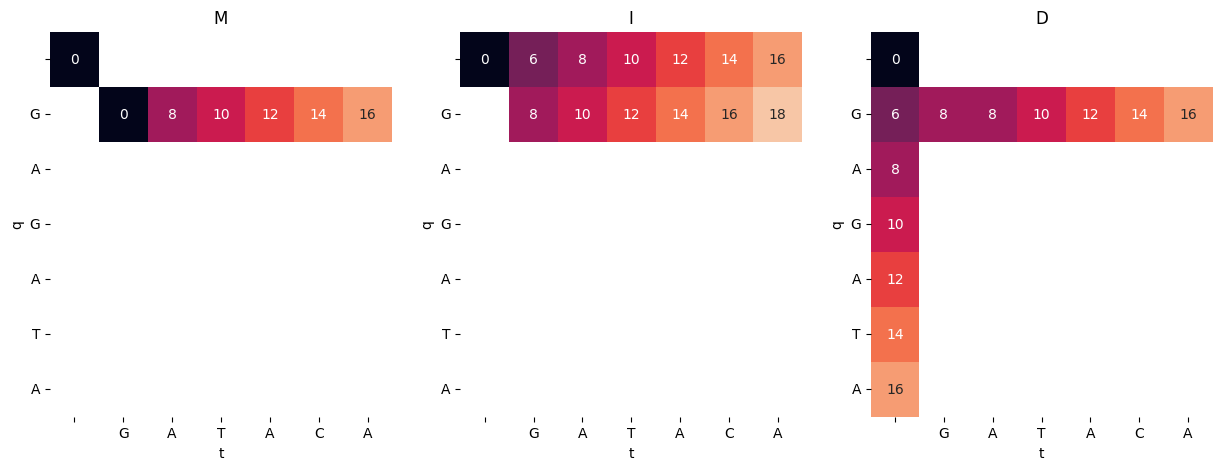

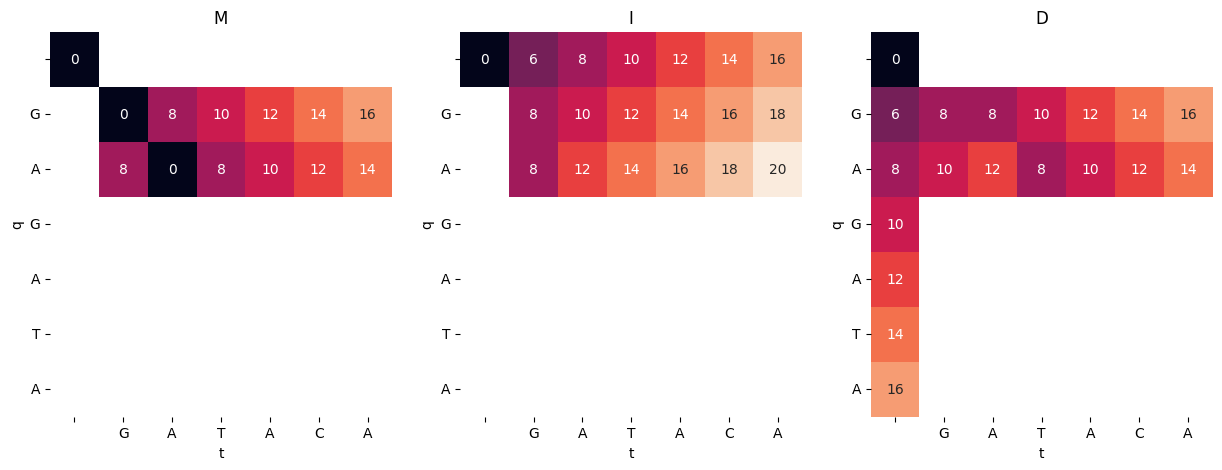

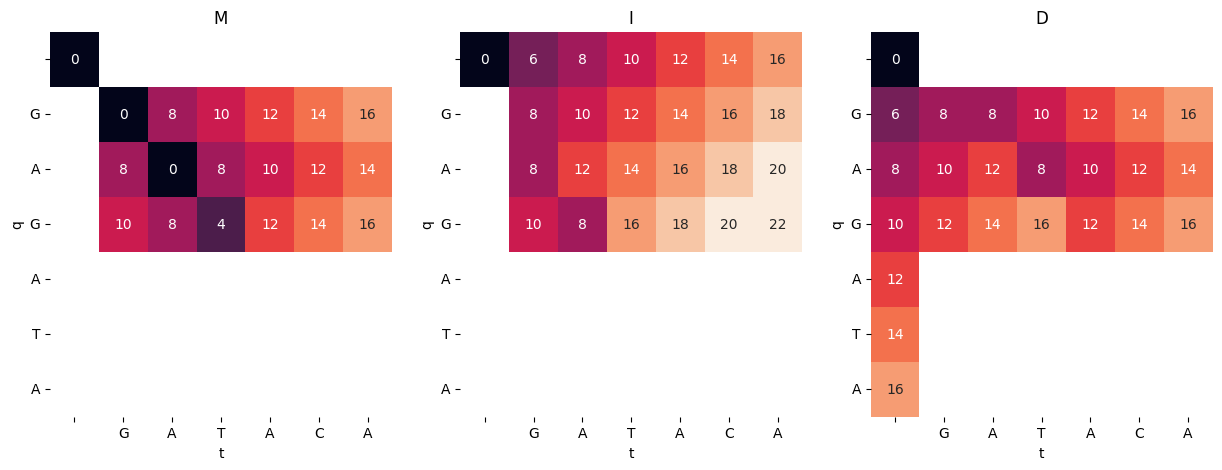

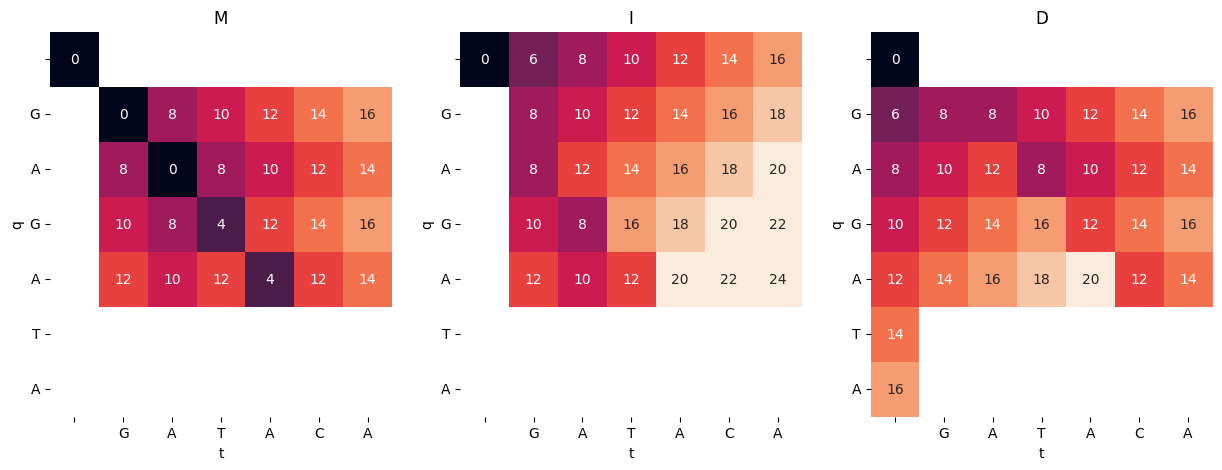

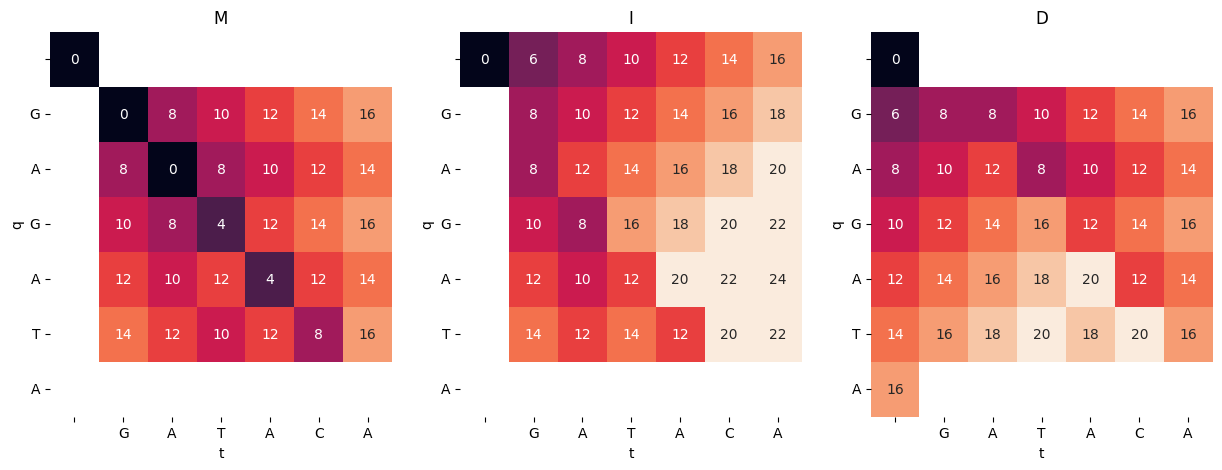

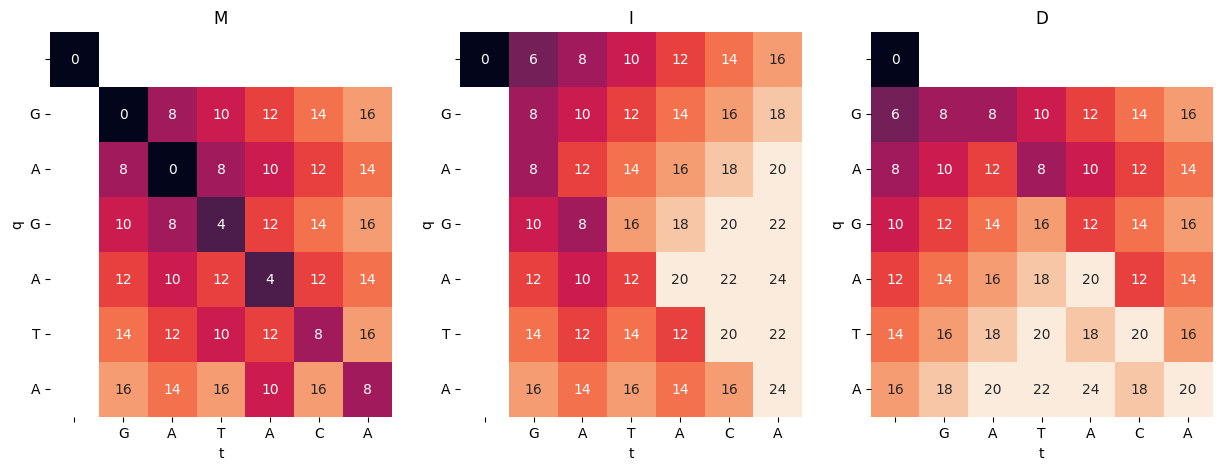

In [479]:
swg(q,t)

In [492]:
def wf_align(q,t):

    def print_wfs(s, figure, i):
        matrix = np.zeros((len(wf[s]['M']['offsets']),len(wf[s].keys())), dtype=float)
        #set the figure size
        # print(n+m+10,i)
        ax = figure.add_subplot(1,n+m+20,i)
        for c,label in enumerate(wf[s].keys()):
            offsets = wf[s][label]['offsets']
            matrix[:,c] = np.hstack([offsets[m+1:],offsets[0:n+1]])
        sns.heatmap(matrix,annot=True,fmt=".0f",cbar=False, vmin=0, vmax=20, ax=ax)
        ax.set_xlabel("component")
        ax.set_ylabel("k")
        ax.set_yticks([k+0.5 for k in range(0,len(offsets))], labels=[k for k in range(-m,+n+1)])
        ax.set_xticks([0.5,1.5,2.5],labels=['M','I','D'])
        ax.set_title(f"WF_{s}")
        
    def init_wf(s, use_prev=False):
        if use_prev :
            if (s-x in wf.keys()):
                wf[s] = wf[s-x].copy()
                wf[s]['M']['offsets'] = wf[s]['M']['offsets']+1
        else:
            wf[s] = {'M':{}, 'I':{}, 'D':{}}
            offsets_len = n+m+1
            wf[s]['M']['offsets'] = np.full(offsets_len, -np.inf, dtype=float)
            wf[s]['D']['offsets'] = np.full(offsets_len, -np.inf, dtype=float)
            wf[s]['I']['offsets'] = np.full(offsets_len, -np.inf, dtype=float)
            if s==0:
                wf[s]['M']['lo'] = wf[s]['D']['lo'] = wf[s]['I']['lo'] = 0
                wf[s]['M']['hi'] = wf[s]['D']['hi'] = wf[s]['I']['hi'] = 0
            

    def wf_extend(s, plot=True):
        
        try: # This exception is needed for the nonexisting wavefronts
            if plot:
                figure = plt.figure(figsize=(30,3))
                i=1
            for k in range(wf[s]['M']['lo'],wf[s]['M']['hi']+1):
                v = int(max(0, wf[s]['M']['offsets'][k])) - k
                h = int(max(0, wf[s]['M']['offsets'][k]))    
                print(f"Starting from v,h= {v,h}")        
                while v<len(q) and h<len(t) and q[v]==t[h]:
                    wf[s]['M']['offsets'][k] = wf[s]['M']['offsets'][k] + 1
                    v = v + 1
                    h = h + 1
                    if plot:
                        print_wfs(s, figure, i)
                        i = i + 1
            if plot:
                plt.title(f"WF_{s} extension")
                plt.show()

        except KeyError:
            pass

        

    def wf_next(s, plot=True):
        init_wf(s)

        try:
            hi = max(wf[s-x]['M']['hi'], wf[s-o-e]['M']['hi'], wf[s-e]['I']['hi'], wf[s-e]['D']['hi']) + 1
        except KeyError:
            hi=0
        try:
            lo = min(wf[s-x]['M']['lo'], wf[s-o-e]['M']['lo'], wf[s-e]['I']['lo'],wf[s-e]['D']['lo']) - 1
        except KeyError:
            lo=0

        print(f"s={s} hi={hi},lo={lo}")
        if plot:
            figure = plt.figure(figsize=(30,3))
            i=1
        for k in range(lo, hi+1):
            wf[s]['I']['offsets'][k] = max(wf[s-o-e]['M']['offsets'][k-1], wf[s-e]['I']['offsets'][k-1]) + 1
            wf[s]['D']['offsets'][k] = max(wf[s-o-e]['M']['offsets'][k+1], wf[s-e]['D']['offsets'][k+1])
            wf[s]['M']['offsets'][k] = max(wf[s-x]['M']['offsets'][k]+1, wf[s]['I']['offsets'][k], wf[s]['D']['offsets'][k])
            
            if plot:
                print_wfs(s, figure, i)
                i = i + 1
        if plot:
            plt.title(f"WF_{s} next")
            plt.show()

        # Equation 3
        wf[s]['M']['hi'] = wf[s]['D']['hi'] = wf[s]['I']['hi'] = hi
        wf[s]['M']['lo'] = wf[s]['D']['lo'] = wf[s]['I']['lo'] =  lo
        
    wf = {}
    DP_matrices = {'M': np.full((len(q)+1,len(t)+1),-np.inf), 'I': np.full((len(q)+1,len(t)+1),-np.inf), 'D': np.full((len(q)+1,len(t)+1),-np.inf)}
    # diagonal and offset to (n,m)
    n = len(q)
    m = len(t)

    Ak = m-n
    Aoffset = m

    s = 0

    for s in range(-o-e,1):
        init_wf(s, use_prev=False)
    
    wf[0]['M']['offsets'][0] = 0

    def assign_matrix_values(matrix_name, s):
        try:
            for k in range(wf[s][matrix_name]['lo'], wf[s][matrix_name]['hi']+1):
                try:
                    v = int(wf[s][matrix_name]['offsets'][k] - k)
                    h = int(wf[s][matrix_name]['offsets'][k]) 
                    DP_matrices[matrix_name][v,h] = s
                except:
                    pass
        except KeyError:
            pass

    while True:
        
        wf_extend(s)
        for matrix_name in ['M','I','D']:
            assign_matrix_values(matrix_name, s)
        
        visualize_matrices(q,t,DP_matrices['M'],DP_matrices['I'],DP_matrices['D'])

        # print(wf[s]['M']['offsets'][Ak], Aoffset)
        if wf[s]['M']['offsets'][Ak] >= Aoffset:
            break
        # assign the scor values to the DP matrix
        
        s = s + 1
        wf_next(s)



Starting from v,h= (0, 0)
[  1. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [  1. -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[  2. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [  2. -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


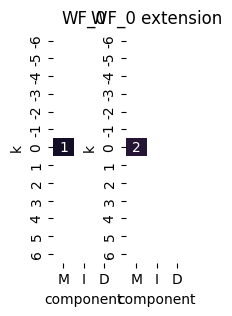

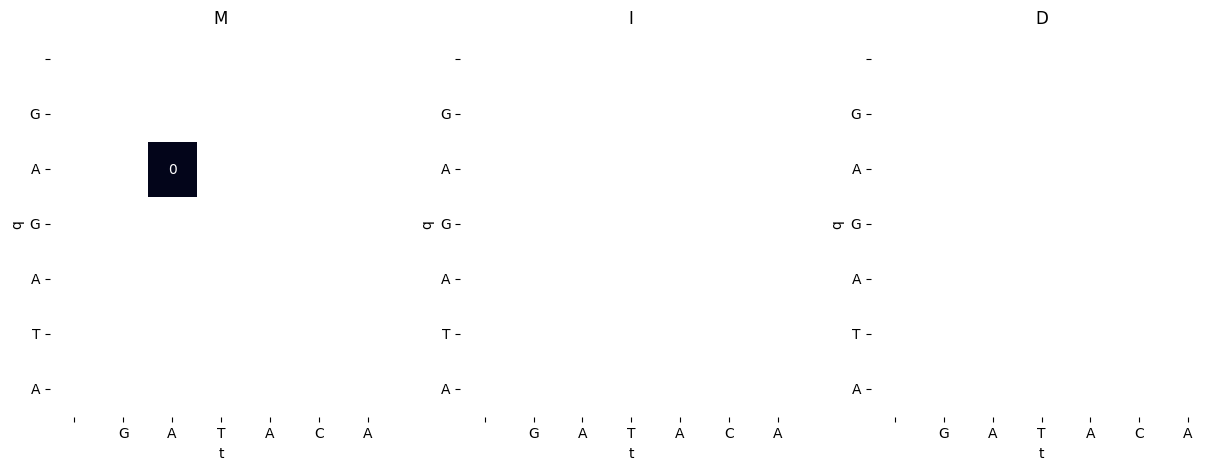

s=1 hi=0,lo=0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


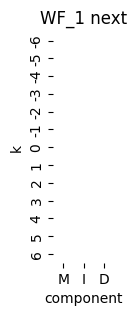

Starting from v,h= (0, 0)
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


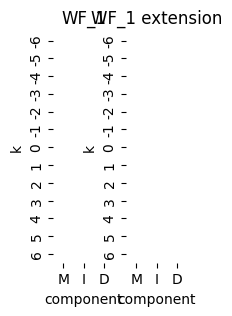

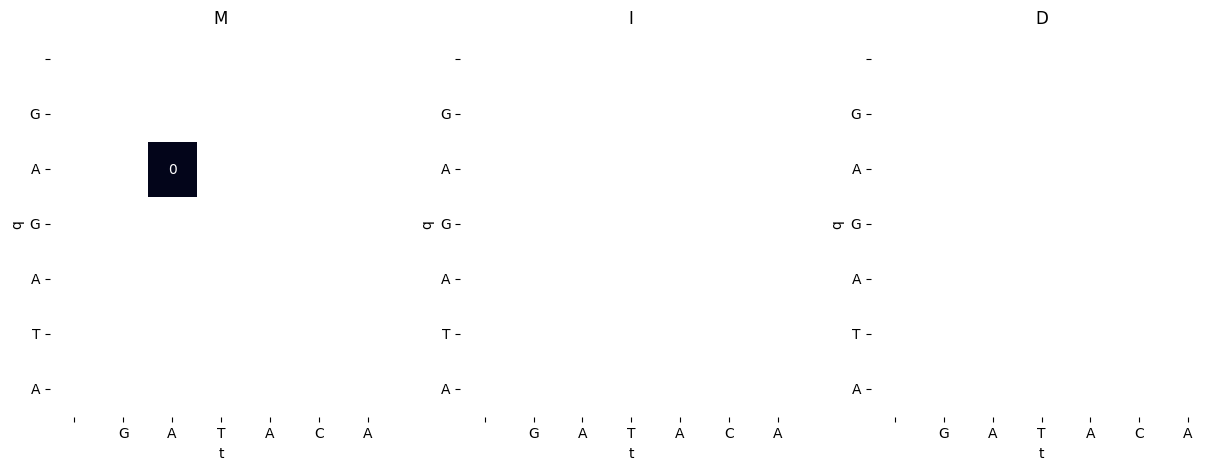

s=2 hi=0,lo=0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


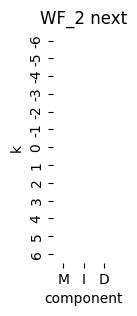

Starting from v,h= (0, 0)
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


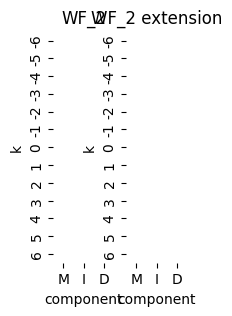

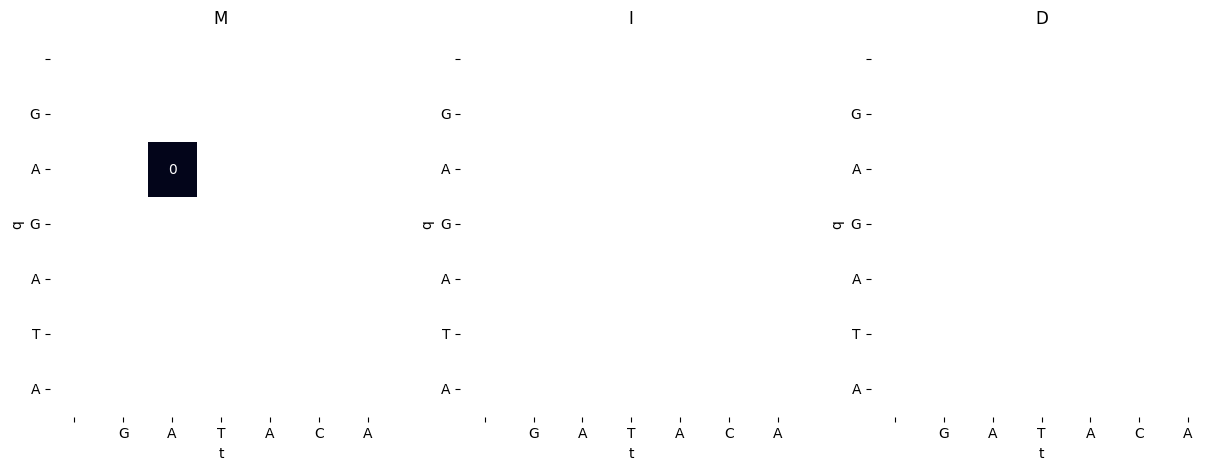

s=3 hi=0,lo=0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


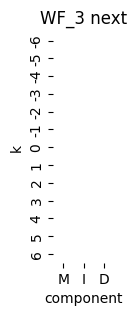

Starting from v,h= (0, 0)
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


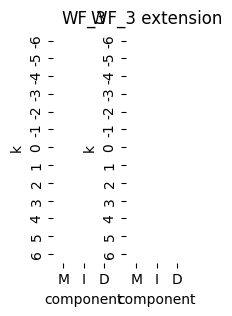

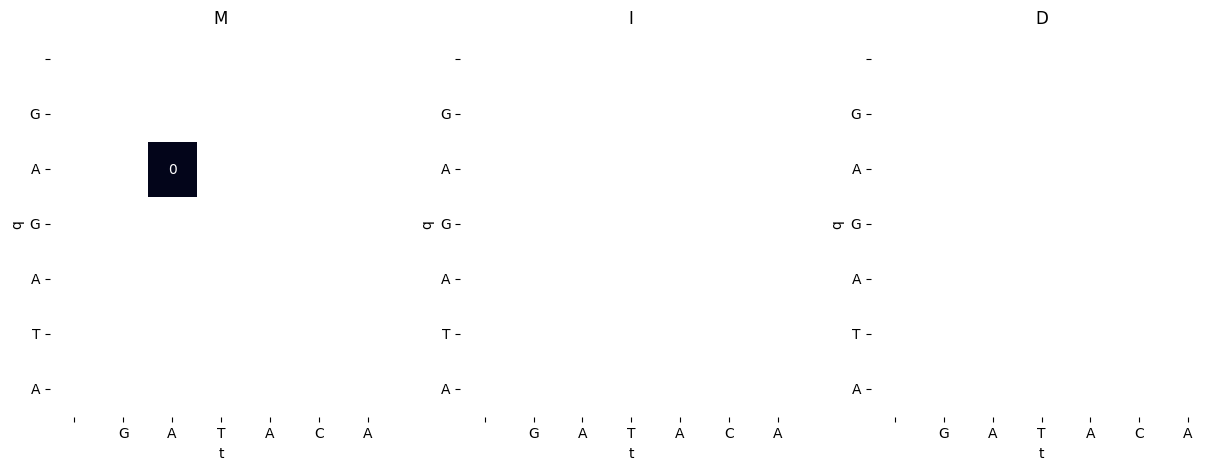

s=4 hi=0,lo=0
[  3. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [  3. -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


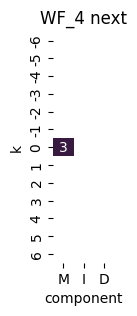

Starting from v,h= (3, 3)
[  4. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [  4. -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


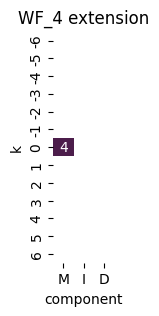

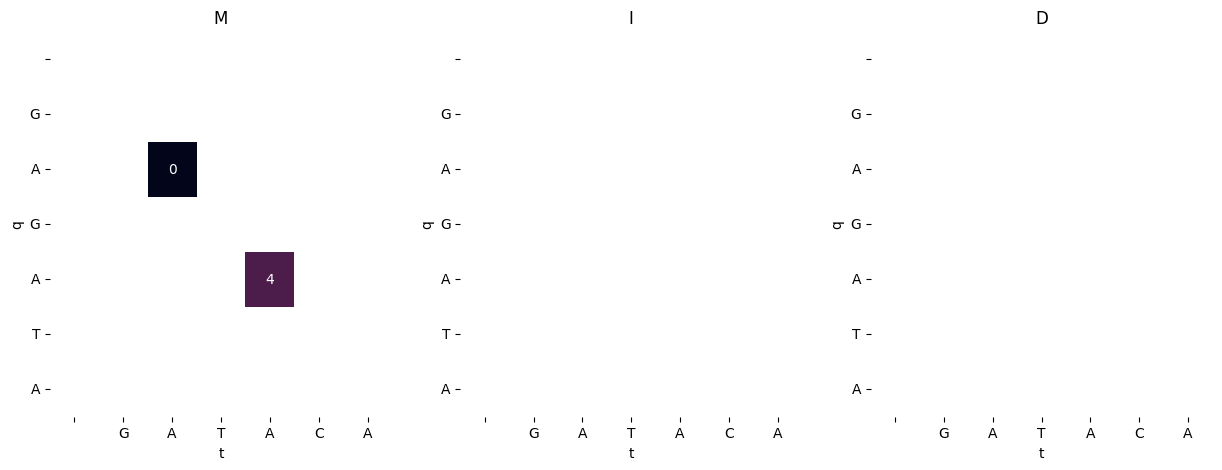

s=5 hi=0,lo=0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


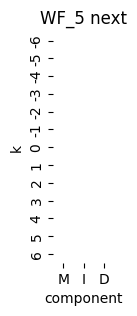

Starting from v,h= (0, 0)
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


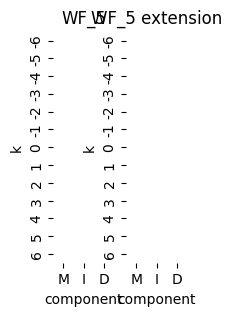

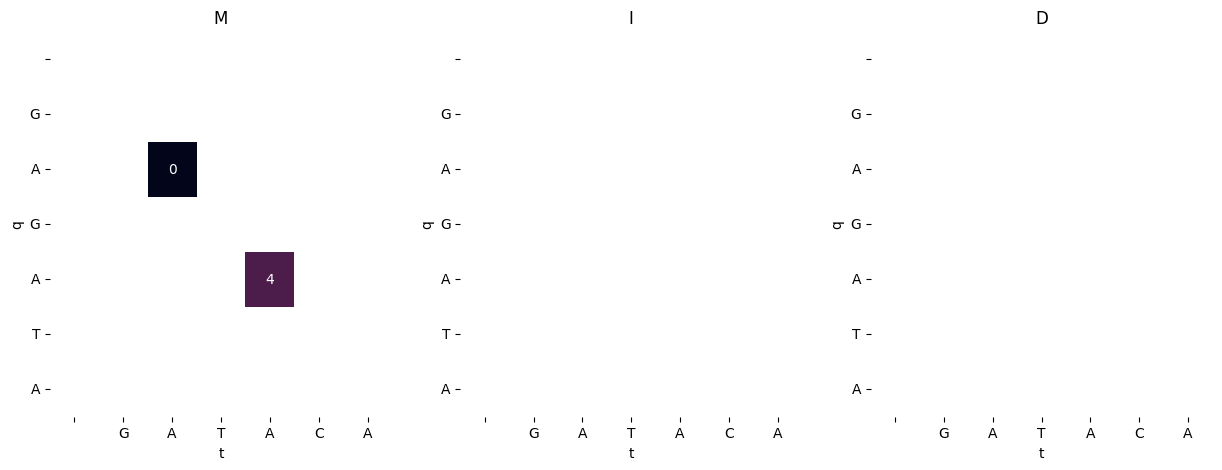

s=6 hi=0,lo=0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


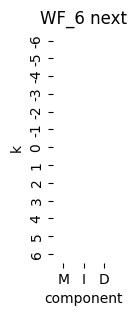

Starting from v,h= (0, 0)
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


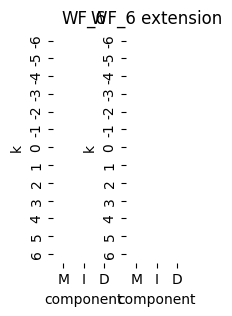

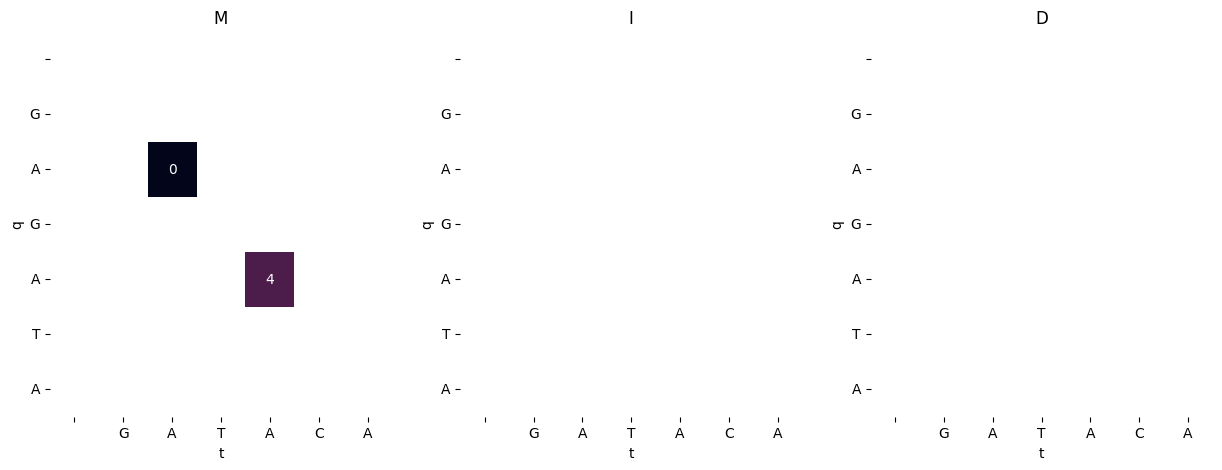

s=7 hi=0,lo=0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


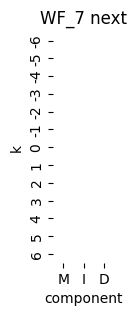

Starting from v,h= (0, 0)
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]


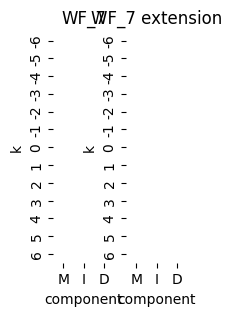

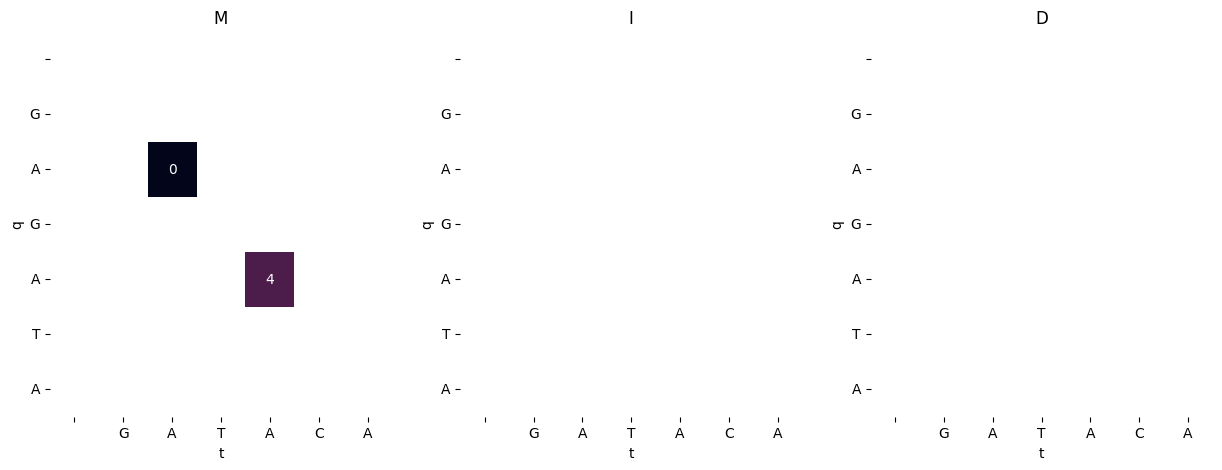

s=8 hi=1,lo=-1
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [-inf -inf -inf -inf -inf -inf]
[  5. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [  5. -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf -inf -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [-inf -inf -inf -inf -inf -inf]
[  5.   3. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [  5.   3. -inf -inf -inf -inf]
[-inf   3. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf   3. -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [-inf -inf -inf -inf -inf -inf]


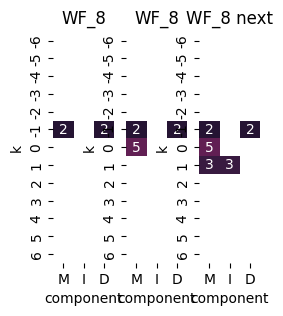

Starting from v,h= (3, 2)
Starting from v,h= (5, 5)
[  6.   3. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [  6.   3. -inf -inf -inf -inf]
[-inf   3. -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [] [-inf   3. -inf -inf -inf -inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf   2.] [] [-inf -inf -inf -inf -inf -inf]
Starting from v,h= (2, 3)


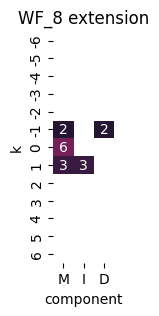

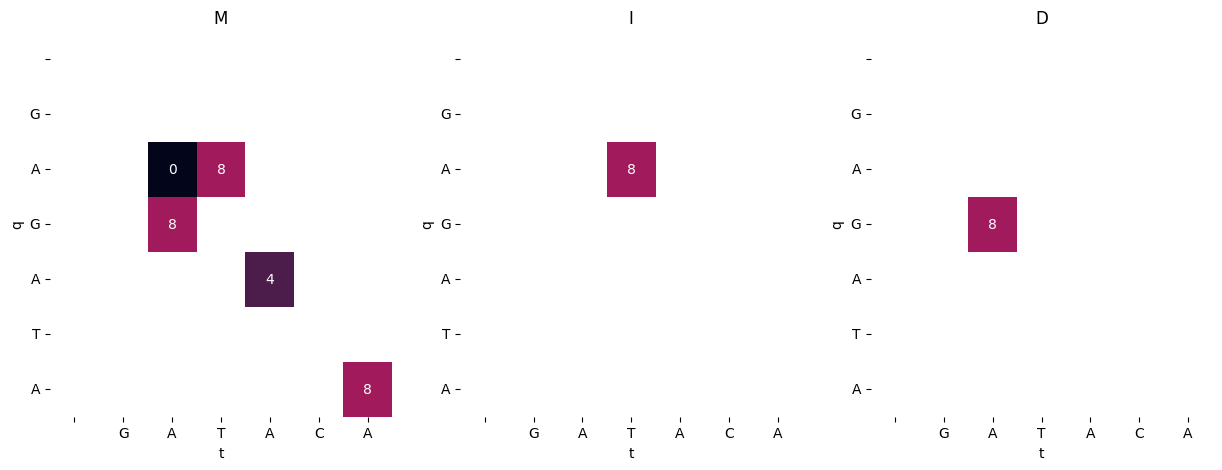

In [493]:
wf_align(q,t)